In [103]:
import tqdm as notebook_tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim

from sklearn.metrics import r2_score

#import torch.nn.functional as F
#
#import torch.nn.init as init

#%matplotlib inline
#import matplotlib

#from torch.nn.parameter import Parameter

In [123]:
# Gathering the sample data
minx = -4*np.pi
maxx = 4*np.pi
n_samples = 1000

x = np.arange(minx, maxx, (maxx-minx)/n_samples)
y = np.cos(x)

data = np.empty([n_samples, 2])
data[:,0] = x
data[:,1] = y

np.random.shuffle(data)

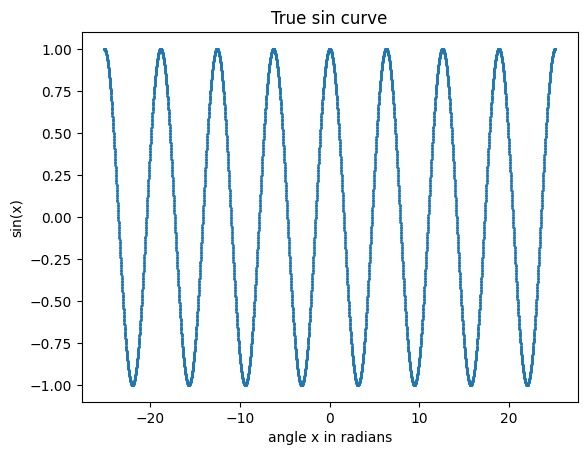

In [124]:
# Plotting reference function
plt.figure()
plt.scatter(data[:,0],data[:,1],s = 1)
plt.title("True cos curve")
plt.xlabel("angle x in radians")
plt.ylabel("cos(x)")
plt.show()

In [125]:
# Splitting data into training, testing and validation
percentage_train = 0.7
percentage_test = 0.2
percentage_validation = 1 - percentage_train - percentage_test

N_train = int(np.floor(percentage_train*np.size(data[:,0])))
N_test = int(np.floor(percentage_test*np.size(data[:,0])))
N_validation = int(np.floor(percentage_validation*np.size(data[:,0])))
print("Number of training data sets:", N_train)
print("Number of test data sets:", N_test)
print("Number of validation data sets:", N_validation)

train = data[:N_train,:]
train_x = data[:N_train - 1, 0]
train_y = data[:N_train - 1, 1]

test = data[N_train: N_train + N_test - 1,:]
test_x = data[N_train: N_train + N_test - 1, 0]
test_y = data[N_train: N_train + N_test - 1, 1]

validation = data[N_train + N_test: , :]
validation_x = data[N_train + N_test: , 0]
vaildation_y = data[N_train + N_test: , 1]

print("Dimensions of data sets:", np.shape(data))
print("Dimensions of training data sets:", np.shape(train))
print("Dimensions of test data sets:", np.shape(test))
print("Dimensions of validation data sets:", np.shape(validation))

Number of training data sets: 3500
Number of test data sets: 1000
Number of validation data sets: 500
Dimensions of data sets: (5000, 2)
Dimensions of training data sets: (3500, 2)
Dimensions of test data sets: (999, 2)
Dimensions of validation data sets: (500, 2)


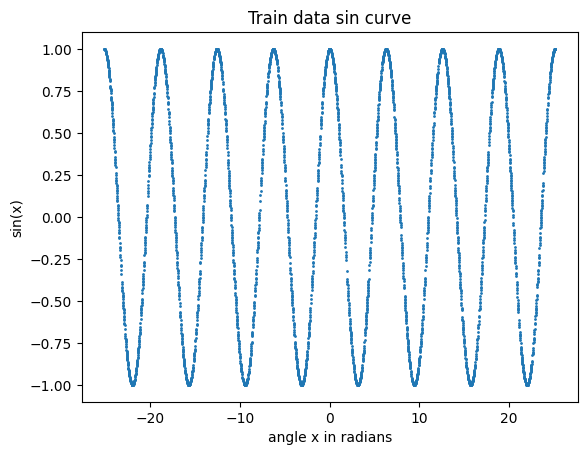

In [126]:
# Train data visualization
plt.figure()
plt.scatter(train[:,0],train[:,1], s = 1)
plt.title("Train data cos curve")
plt.xlabel("angle x in radians")
plt.ylabel("cos(x)")
plt.show()

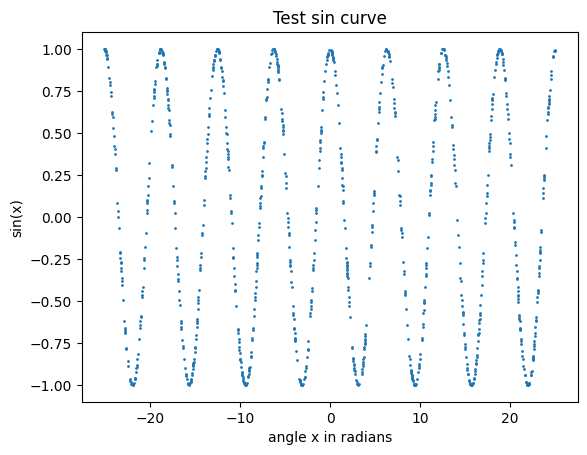

In [127]:
# Test data visualization
plt.figure()
plt.scatter(test[:,0],test[:,1], s = 1)
plt.title("Test cos curve")
plt.xlabel("angle x in radians")
plt.ylabel("cos(x)")
plt.show()

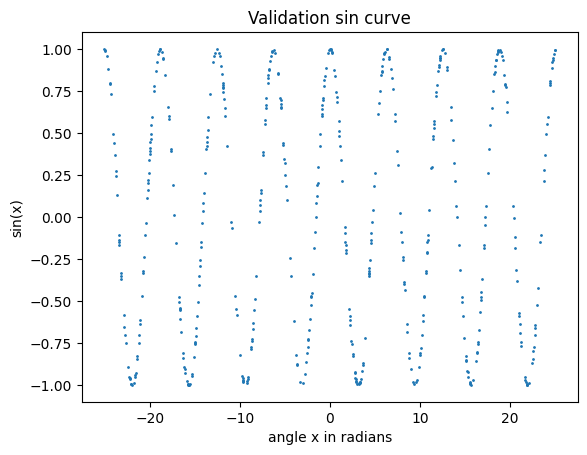

In [128]:
# Validation data visualization
plt.figure()
plt.scatter(validation[:,0],validation[:,1], s = 1)
plt.title("Validation cos curve")
plt.xlabel("angle x in radians")
plt.ylabel("cos(x)")
plt.show()

In [129]:
#Change numpy array to tensor
train_x = torch.from_numpy(train[:,0]).unsqueeze(1).float()
train_y = torch.from_numpy(train[:,1]).unsqueeze(1).float()
test_x = torch.from_numpy(test[:,0]).unsqueeze(1).float()
test_y = torch.from_numpy(test[:,1]).unsqueeze(1).float()

In [130]:
# define network architecture
input_dim = 1
output_dim = 1
num_hidden = 300

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.Sigmoid(),
            nn.Linear(num_hidden, output_dim),
        )

    def forward(self, x):
        y_out = self.linear_relu_stack(x)
        return y_out
    
net = Net(num_hidden)
    
# hyperparameters
learning_rate = 1e-5
batch_size = 50
num_epochs = 2000

#loss
loss_fn = nn.MSELoss()

#optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Epoch  1 : Train Loss 0.900206 , Train r2 -0.047762, Test r2 -0.035388
Epoch 51 : Train Loss 0.681271 , Train r2 0.034202, Test r2 0.027205
Epoch 101 : Train Loss 0.658103 , Train r2 0.067104, Test r2 0.057686
Epoch 151 : Train Loss 0.636679 , Train r2 0.097465, Test r2 0.085691
Epoch 201 : Train Loss 0.618657 , Train r2 0.122962, Test r2 0.108671
Epoch 251 : Train Loss 0.604236 , Train r2 0.143362, Test r2 0.126509
Epoch 301 : Train Loss 0.592125 , Train r2 0.160512, Test r2 0.141178
Epoch 351 : Train Loss 0.581701 , Train r2 0.175291, Test r2 0.154058
Epoch 401 : Train Loss 0.572648 , Train r2 0.188141, Test r2 0.165679
Epoch 451 : Train Loss 0.564686 , Train r2 0.199450, Test r2 0.176079
Epoch 501 : Train Loss 0.557603 , Train r2 0.209514, Test r2 0.185504
Epoch 551 : Train Loss 0.551333 , Train r2 0.218420, Test r2 0.194112
Epoch 601 : Train Loss 0.545796 , Train r2 0.226285, Test r2 0.201982
Epoch 651 : Train Loss 0.540815 , Train r2 0.233358, Test r2 0.209239
Epoch 701 : Train Lo

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

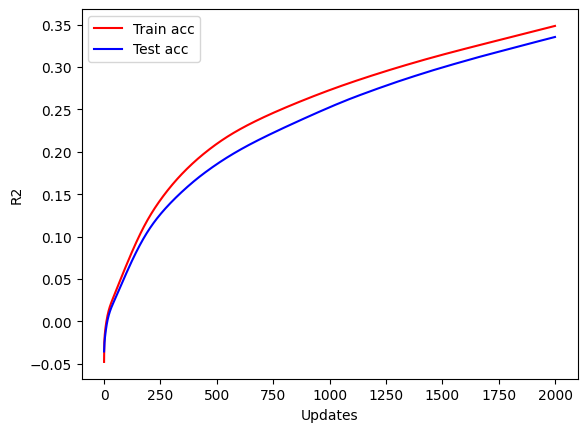

In [131]:
# train network

#getting epoch sizes
num_samples_train = train_x.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_test = test_x.shape[0]
num_batches_test = num_samples_test // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        # compute gradients given loss
        y_batch = train_y[slce]
        batch_loss = loss_fn(output, y_batch)
        batch_loss.backward()
        optimizer.step()

        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        preds = output.squeeze(1)

        train_targs += list(train_y[slce].numpy())
        train_preds += list(preds.data.numpy())

    ### Evaluate test
    test_preds, test_targs = [], []
    for i in range(num_batches_test):
        slce = get_slice(i, batch_size)

        output = net(test_x[slce])
        preds = output.squeeze(1)
        test_targs += list(test_y[slce].numpy())
        test_preds += list(preds.data.numpy())


    train_r2 = r2_score(train_targs, train_preds)
    test_r2 = r2_score(test_targs, test_preds)

    train_acc.append(train_r2)
    test_acc.append(test_r2)

    if epoch % 50 == 0:
        print("Epoch %2i : Train Loss %f , Train r2 %f, Test r2 %f" % (
                epoch+1, losses[-1], train_r2, test_r2))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train acc','Test acc'])
plt.xlabel('Updates'), plt.ylabel('R2')

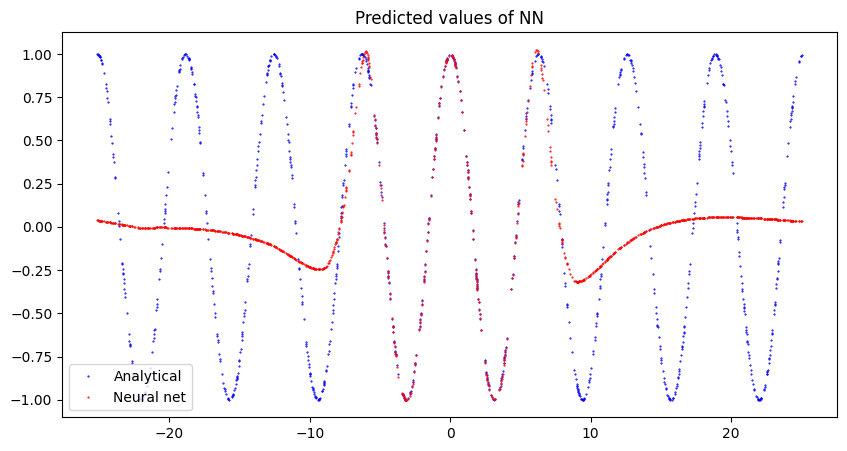

In [132]:
 # evaluate network at different points, show results
test_y_eval = net(test_x) #predictes y values of test set of the trained model
test_y_eval_np = test_y_eval.detach().numpy() #converts it to numpy array

# plot analytical solution vs predicted values of test set
plt.figure(figsize=(10, 5))
plt.plot(test[:,0], test[:,1], color = "blue", marker='o', linestyle='none', markersize=0.5)
plt.plot(test[:,0], test_y_eval_np, color = "red", marker='o', linestyle='none', markersize=0.5)
plt.title("Predicted values of NN")
plt.legend(["Analytical", "Neural net"], loc="lower left")